In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import sem
import matplotlib.cm as cm
import pickle
import pandas as pd
import h5py
import configs
import torch

# Global variables

In [7]:
model = 'pnet'

ERROR! Session/line number was not unique in database. History logging moved to new session 1127


In [8]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn_vision_resnet/'
dataset_root = '/mnt/smb/locker/abbott-locker/hcnn_vision_resnet/imagenet/'
ckpt_root = f'{engram_dir}checkpoints/'
hps_root = f'{engram_dir}hyperparams/'
activations_root = f'{engram_dir}activations/'

# Helper functions

In [13]:
def get_accuracy(results):
    labels = np.array(results['labels'])
    timesteps = []
    accuracies = []
    
    n_timesteps = 5
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'label_{t}'][i]
            acc_t = float(output==label)
            timesteps.append(t)
            accuracies.append(acc_t)
            
    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    np.mean(accuracies)
    return timesteps, accuracies

In [14]:
def get_data(model):
    data = {}
    data['Accuracy'] = [] # p
    data['$\Delta$ Accuracy'] = [] # p - p_ff for each bg, snr
    data['Timesteps'] = []
    data['Noise Level'] = []
    data['BG'] = []
    data['ID'] = []

    for noise_dir in os.listdir(f'{activations_root}{model}'):
        if '_lvl_' not in noise_dir: continue
        bg, noise_level = noise_dir.split('_lvl_')
        activ_dir = f'{activations_root}{model}/{noise_dir}/'
        for results_file in os.listdir(activ_dir):
            results_filepath = f'{activ_dir}{results_file}'
            try:
                results = h5py.File(results_filepath, 'r')
            except:
                print(results_filepath)
                traceback.print_exc()
                continue
            timesteps, accs = get_accuracy(results)

            # Collect accuracy results by labels
            ff_acc = None
            for t in [0, 1, 2, 3, 4]:
                if t == 0:
                    ff_acc = np.mean(accs[timesteps==0])
                idxs = timesteps==t
                t_acc = np.mean(accs[idxs])
                data['Accuracy'].append(t_acc)
                data['$\Delta$ Accuracy'].append(t_acc - ff_acc)
                data['Timesteps'].append(t)
                data['Noise Level'].append(int(noise_level))
                data['BG'].append(bg)
                data['ID'].append(results_file)
    df = pd.DataFrame(data)

    bg_avgs = {}
    for bg in np.unique(df['BG']):
        bg_avgs[bg] = {}
        for noise_level in np.unique(df['Noise Level']):
            ff_df = df[df['Timesteps']==0]
            bg_avgs[bg][noise_level] = np.mean(
                ff_df[(ff_df['BG'] == bg) & (ff_df['Noise Level'] ==noise_level)]['Accuracy']
                )
    data['Relative Accuracy'] = [] # (p - p_ff)/p_ff
    for idx in range(len(data['Accuracy'])):
        bg = data['BG'][idx]
        noise_level = data['Noise Level'][idx]
        delta_acc = data['$\Delta$ Accuracy'][idx]
        data['Relative Accuracy'].append(delta_acc/bg_avgs[bg][noise_level])
    df = pd.DataFrame(data)
    return df

# Collect Data

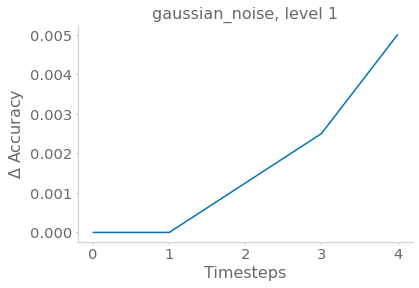

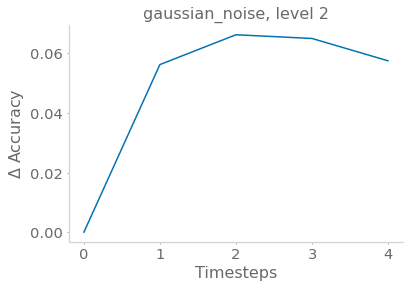

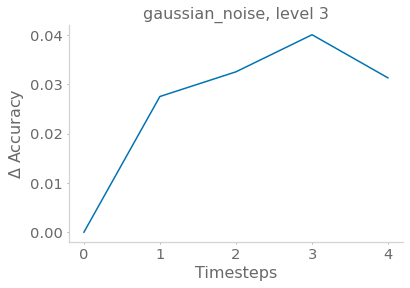

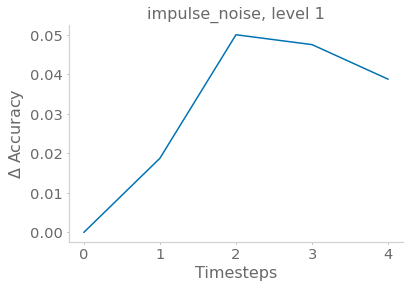

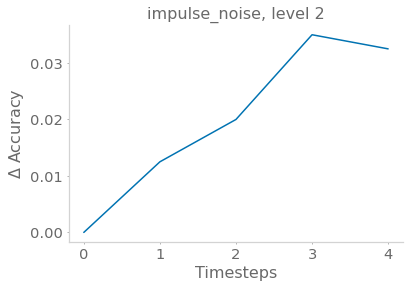

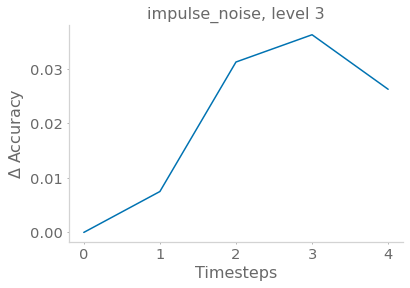

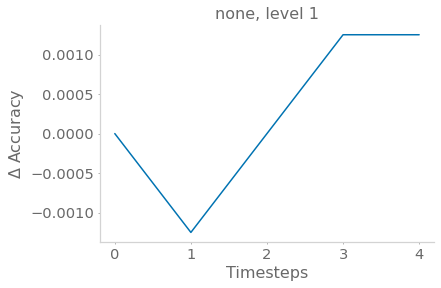

In [17]:
for noise_type in ['gaussian_noise', 'impulse_noise', 'none']:
    for noise_level in [1, 2, 3]:
        _df = df[(df['BG']==noise_type) & (df['Noise Level']==noise_level)]
        if _df.size == 0: continue
        fig, ax = plt.subplots()
        sns.lineplot(x='Timesteps', y='$\Delta$ Accuracy', data=_df, ax=ax)
        ax.set_title(f'{noise_type}, level {noise_level}')
        plt.show()